In [1]:
# 这部分是模板，用于 Jupyter lab 文件的初始导入和设置。
# 1. import built-in library
from copy import deepcopy
import functools
import json
import math
import os
from random import shuffle
import sys
import time

# 2. import 3rd party library
import cv2 as cv
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import ImageOps
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

rng = np.random.default_rng()

# setup for the jupyter to show all results within one cell
InteractiveShell.ast_node_interactivity = "all"

# 下面 2 行，设置实时更新导入的外部 python 程序
%load_ext autoreload
%autoreload 2

# 控制显存.
config=tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True  # 设置动态分配 GPU 内存
sess=tf.compat.v1.Session(config=config)

tf.config.list_physical_devices('GPU')

# YOLO-V4-CSP模型用到 math.atan ，因为 TF 2.4 不支持使用 float16 计算 math.atan， 所以在 TF 2.4 中不使用混合精度 mixed precision。在 TF 2.8 中支持使用 float16 计算 math.atan，已经可以用混合精度进行加速。
# 但是因为在损失函数中，计算数值超过 float16 表达范围，所以 YOLO-V4-CSP 依然无法使用混合精度加速。

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.__version__

'2.9.1'

In [3]:
import vision_transformer_detector
from vision_transformer_detector import Constants
from vision_transformer_detector import visualize_predictions
# visualize_predictions?

import vision_transformer_utilities
from vision_transformer_utilities import coco_data_vision_transformer
from vision_transformer_utilities import CATEGORIES_TO_DETECT

Extracting the annotations for train dataset ...
849281/860001 [==========================================================>.] - ETA: 0s
Done. Here are 2 fixed records.
Height was 0, set to 1. 	Image: 200365	category_id: 58,	annotation index: 3,	object center 297.2, 388.3, 
Height was 0, set to 1. 	Image: 550395	category_id: 1,	annotation index: 846309,	object center 12.8, 188.6, 
Extracting the annotations for validation dataset ...
34688/36781 [=======================================================>....] - ETA: 0s

In [4]:
batch_size = 8
# 创建训练集和验证集。
validation_dataset = coco_data_vision_transformer(
    dataset_type='validation', images_range=(0, 500), batch_size=batch_size)  
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(8, 608, 608, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 17, 6), dtype=tf.float32, name=None))>

In [5]:
start_image = 8
# 为了快速展现模型的过拟合能力，下面只使用 8 张图片进行演示。如果有 GPU 集群对模型进行训练，则可以使用任意数量的图片。
images_quantity = 8 
train_dataset = coco_data_vision_transformer(
    dataset_type='train', images_range=(start_image, start_image+images_quantity),
    shuffle_images=False, batch_size=batch_size)  

train_dataset.element_spec
print(f'len(train_dataset):\t{len(train_dataset)!r}')

(TensorSpec(shape=(8, 608, 608, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(8, 17, 6), dtype=tf.float32, name=None))

len(train_dataset):	1


In [6]:
# 设置 2 个路径，用在自动保存模型的 callbacks 中。要保存 2 个模型，一个是最高 AP 值模型，另外一个是持续训练模型（即每个 epoch 结束后就保存一次的模型）。
ongoing_training_model_name = 'ongoing_training_vision_transformer_detector'
ongoing_training_model_path = f'checkpoints/{ongoing_training_model_name}.keras'  

highest_ap_model_name = 'highest_ap_vision_transformer_detector'
highest_ap_model_path = f'checkpoints/{highest_ap_model_name}.keras'

In [7]:
# 创建一个空的表格，用于记录训练数据，统计均值和标准差。
# counter_records 用于计数，必须和表格同时初始化。
records = pd.DataFrame({})
counter_records = 0

In [8]:
tic = time.time()

# 以下 3 个设置为学习率衰减设置，可以进行 2 次衰减。
# 阶梯衰减也可以用 keras.optimizers.schedules.PiecewiseConstantDecay
epochs_first_lr_decay = 1_000  # 1_000
epochs_second_lr_decay = 9_000  # 70_000
epochs_third_lr_decay = 1_000
rate_lr_decay = 0.1 

# 允许发生学习率衰减的次数。
allowed_decay_times = 3
# 全局变量名字前应该使用 _
vision_transformer_detector._allowed_decay_times.assign(allowed_decay_times)  
learning_rate_step_decay = functools.partial(
    vision_transformer_detector.learning_rate_step_decay, 
    epochs_first_lr_decay=epochs_first_lr_decay, 
    epochs_second_lr_decay=epochs_second_lr_decay, 
    epochs_third_lr_decay=epochs_third_lr_decay, rate_lr_decay=rate_lr_decay) 

lr_decay_callback = keras.callbacks.LearningRateScheduler(learning_rate_step_decay)

# check_weight_callback = vision_transformer_detector.CheckModelWeight(
#     start_epochs=1, skip_epochs=100, weight_threshold=10)  # 如果需要检查权重，可以使用该 callback。

# numbers = 5  # 根据快速排序算法，应该每次使用 4 或 5 个数据点，才能尽快找到最佳超参。
# learning_rates = np.logspace(np.log10(8e-4), np.log10(2e-5), num=numbers)
# learning_rates = np.linspace(4e-4, 8e-5, num=numbers)  # 0.1
# learning_rates = [8e-05]  
learning_rate = 8e-05  

patch_size_list = [17]  
embedding_dim_list = [28] 

epochs = 12_502  # 15_200

repeats = 1  # 当需要统计均值和标准差时，会用到 repeats，即下面的 repeats_count_down。
count_down = len(patch_size_list) 

# 寻找超参时，可以用下面的 for 循环遍历搜索列表。
for patch_size in patch_size_list:
    for embedding_dim in embedding_dim_list:                                 
                        
        current_toc = time.time()
        current_duration = current_toc - tic
        current_minutes = current_duration / 60
        current_hours_spent = current_minutes / 60 

        print(f'learning_rate: {learning_rate:.2e}, epochs: {epochs:,}, count_down: {count_down}.')
        print(f'minutes_spent: {current_minutes:.0f}. hours_spent: {current_hours_spent:.1f}.')

        print(f'time:\t{time.strftime("%B-%d,  %X")}')

        count_down -= 1

        last_losses = []
        min_losses = []
        best_aps = []

        repeats_count_down = repeats  # 当需要统计均值和标准差时，会用到 repeats_count_down。
        for i in range(repeats):

            print(f'repeats_count_down: {repeats_count_down}.')
            repeats_count_down -= 1  

# =======仅在寻找 lr 等超参时需要使用这部分代码。对每个不同的超参组合，使用一个新的 model。=============================

            vision_transformer_model = vision_transformer_detector.create_vision_transformer_detector(
                patch_size=patch_size, embedding_dim=embedding_dim,  
                encoder_num_heads=8, encoder_key_dim=40, 
                dropout=None,
                encoder_mlp_quantities=8,
                encoder_repeat_times=8,
                mlp_head_last_units=136, 
                mlp_head_dense_layers_quantity=7,  
                max_weight=10,
                mlp_head_dense_mish_block_repeats=1)

            optimizer_adam = keras.optimizers.Adam(
                learning_rate=learning_rate, clipvalue=10)  # clipvalue 为修剪梯度。

            my_custom_loss = functools.partial(
                vision_transformer_detector.my_custom_loss, 
                focal_binary_loss=True, 
                coefficient=9, exponent=2,
                weight_classification=0.0074,  
                weight_ciou=4.5,  
            ) 
            # Keras 要用到名字属性，所以这里必须定义 __name__
            my_custom_loss.__name__ = 'my_custom_loss'

# ====================== 调用保存好的模型，进行 debug ===============================================
#             custom_objects = {'MishActivation': vision_transformer_detector.MishActivation, 
#                 'ExtractImagePatches':vision_transformer_detector.ExtractImagePatches,
#                 'PositionEncoding':vision_transformer_detector.PositionEncoding,
#                 'ClipWeight': vision_transformer_detector.ClipWeight,
#                 # 因为前面已经定义了 my_custom_loss，所以这里可以直接使用。
#                 # 注意函数的参数值必须是最新的，所以不可以使用 vision_transformer_detector.my_custom_loss 的方式调用。
#                 # 'my_custom_loss':my_custom_loss,  
#                 } 

#             vision_transformer_model = keras.models.load_model(
#                 filepath=highest_ap_model_path,   
#                 custom_objects=custom_objects, compile=False)
# ====================== 调用保存好的模型，进行 debug ===============================================

            vision_transformer_model.compile(
                loss=my_custom_loss, 
                # metrics=[vision_transformer_detector.MeanAveragePrecision()],
                optimizer=optimizer_adam)  
# =======仅在寻找 lr 等超参时需要使用这部分代码。对每个不同的超参组合，使用一个新的 model。=============================

            save_highest_ap_callback = vision_transformer_detector.SaveModelHighestAP(
                evaluation_data=train_dataset, 
                highest_ap_model_path=highest_ap_model_path,  
                epochs_warm_up=500, skip_epochs=1000,  # 900 2_000
                # ap_threashold=0.9951,  # 之前保存的模型，AP 已经达到 0.9983。
                # ongoing_training_model_path=ongoing_training_model_path,
            )
            callbacks_list = [lr_decay_callback, save_highest_ap_callback] 

            history = vision_transformer_model.fit(
                x=train_dataset, epochs=epochs,
                verbose=0,  # 关闭输出显示，避免大量的输出信息导致浏览器卡顿。
                callbacks=callbacks_list,
            )   

            history_dict = history.history 

            loss = history_dict['loss']

            # validation_loss = history_dict['val_loss']

            last_loss = round(loss[-1], 3)
            min_loss = round(np.amin(loss), 3)
            drop_loss = round((loss[0] - loss[-1]), 3)

            last_losses.append(last_loss)
            min_losses.append(min_loss)

            current_best_ap = np.amax(save_highest_ap_callback.ap_record)
            current_best_ap = np.round(current_best_ap, 4)
            best_aps.append(current_best_ap)

        max_weight = vision_transformer_detector.check_weights(
            model_input=vision_transformer_model)
        max_weight = round(max_weight, 1)

        records.loc[counter_records, 'lr'] = f'{learning_rate:.2e}'

        records.loc[counter_records, 'last_loss'] = np.mean(last_losses)
        # records.loc[counter_records, 'min_loss'] = np.mean(min_losses)
        # records.loc[counter_records, 'std_loss'] = f'{np.std(last_losses):.2e}'

        records.loc[counter_records, 'epochs'] = epochs
        # records.loc[counter_records, 'patch_size'] = patch_size
        # records.loc[counter_records, 'embedding_dim'] = embedding_dim

        records.loc[counter_records, 'epochs_lr_decay'] = epochs_first_lr_decay
        records.loc[counter_records, 'epochs_second_lr_decay'] = epochs_second_lr_decay
        records.loc[counter_records, 'allowed_decay_times'] = allowed_decay_times
        # records.loc[counter_records, 'repeats'] = repeats

        records.loc[counter_records, 'best_AP'] = np.mean(best_aps)
        records.loc[counter_records, 'std_AP'] = np.std(best_aps)
        # print(f'current_best_ap: {current_best_ap}')

        counter_records += 1
    
# 
toc = time.time()
duration = toc - tic
minutes = duration / 60
hours_spent = minutes / 60

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=3>

learning_rate: 8.00e-05, epochs: 12,502, count_down: 1.
minutes_spent: 0. hours_spent: 0.0.
time:	September-18,  08:52:33
repeats_count_down: 1.

Checking the AP after epoch 500. The highest AP is: 0.00%
1/1 [==============================] - 8s 8s/step - loss: 2.9804 - AP: 0.4522
The highest AP changed to: 45.22%
The highest AP model is saved.
💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐
Changing the learning rate after epoch 1000:
before change: 	8.00e-05
after change: 	8.00e-06
💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐💐

Checking the AP after epoch 1500. The highest AP is: 45.22%
1/1 [==============================] - 5s 5s/step - loss: 1.0112 - AP: 0.7930
The highest AP changed to: 79.30%
The highest AP model is saved.

Checking the AP after epoch 2500. The highest AP is: 79.30%
1/1 [==============================] - 6s 6s/step - loss: 0.6949 - AP: 0.8625
The highest AP changed to: 86.25%
The highest AP model is saved.

Checking the AP after epoch 3500. The highest AP is: 86.25%
1/1 [==============================] - 6s 6s/ste

In [9]:
time_stamp = time.strftime('%Y-%m-%d-%H%M')  # 盖一个当前时间章。
time_stamp

# 查看训练所用的时间。
f'hours spent: {hours_spent:.1f}'

'2022-09-18-1045'

'hours spent: 1.9'

In [10]:
pd.set_option('display.max_rows', 90)

f'LATEST_RELATED_IMAGES: {Constants.LATEST_RELATED_IMAGES.value}, BBOXES_PER_IMAGE: {Constants.BBOXES_PER_IMAGE.value}'
#f'minutes: {minutes:.1f}'
f'重复 {repeats} 次，计算均值和标准差。'
records.sort_values(by='best_AP', ascending=False)[: 90]

'LATEST_RELATED_IMAGES: 3, BBOXES_PER_IMAGE: 14'

'重复 1 次，计算均值和标准差。'

,lr,last_loss,epochs,epochs_lr_decay,epochs_second_lr_decay,allowed_decay_times,best_AP,std_AP
0,8.00e-05,0.038,12502.0,1000.0,9000.0,3.0,1.0,0.0


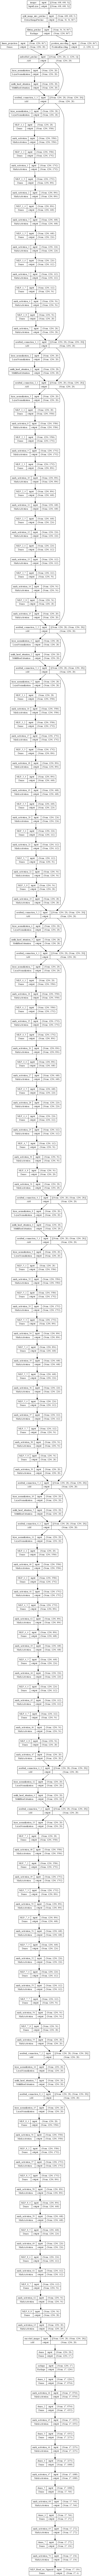

In [11]:
# 画出模型结构图。
keras.utils.plot_model(model=vision_transformer_model, to_file='vision_transformer_model.png', 
                       show_shapes=True, dpi=120)

In [12]:
# 下面画损失值折线图时，要用到这 2 个变量。
epochs_warm_up = save_highest_ap_callback.epochs_warm_up
epochs_warm_up
skip_epochs = save_highest_ap_callback.skip_epochs
skip_epochs

500

1000

In [13]:
# 在一张折线图上同时画出 loss 和 AP。
x = np.arange(1, epochs + 1)
scatters_loss = x, loss, 'loss'

x_ap = x[epochs_warm_up:: skip_epochs]  # 注意有 skip_epochs 的情况，x_ap 的数量会更少。
scatters_ap = x_ap, save_highest_ap_callback.ap_record, 'AP'

scatters_inputs = [scatters_loss, scatters_ap]

graph_title = (f'loss-AP-scatters, \tmax_weight:{max_weight:7_.1f}, \tlearning_rate: {learning_rate:.2e}, '
               f'\tclip_weight=10<br />best_AP: {current_best_ap:.2%}, '  # clip_weight=10
               f'duration: {minutes:.1f} minutes, {hours_spent:.1f} hours, finished time: \t{time_stamp},<br />'
               f'epochs_first_lr_decay:{epochs_first_lr_decay:8_}, '
               f'epochs_second_lr_decay:{epochs_second_lr_decay:8_}, '
               f'epochs_third_lr_decay:{epochs_third_lr_decay:8_}, '
               f'training epochs:{epochs:8_}, allowed_decay_times: {allowed_decay_times}')
titles = graph_title, 'epochs', 'loss'
file_name = f'loss-AP-scatters-{time_stamp}.html'
secondary_y_title = 'AP'

vision_transformer_utilities.scatters_plotly(scatters_inputs, titles, file_name, 
                                             secondary_y=True, secondary_y_title=secondary_y_title)

In [14]:
# 下面查看模型在训练集上的预测效果。
partial_train_dataset = train_dataset.take(1)
partial_train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(8, 608, 608, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 17, 6), dtype=tf.float32, name=None))>

In [15]:
for element in partial_train_dataset:
    partial_images = element[0]
    partial_labels = element[1]

type(partial_images)
partial_images.shape
type(partial_labels)

tensorflow.python.framework.ops.EagerTensor

TensorShape([8, 608, 608, 3])

tensorflow.python.framework.ops.EagerTensor

In [16]:
# 查看当前模型在 partial_train_dataset 上的预测结果。

vision_transformer_model.evaluate(train_dataset)
result = vision_transformer_model.predict(partial_images)

1/1 [==============================] - 2s 2s/step - loss: 0.0290


0.02904941700398922

1/1 [==============================] - 2s 2s/step


In [17]:
# 显示模型预测的结果。按 q 可以查看下一张图片。
object_exist_confidence_threshold = 0.5
classification_confidence_threshold = 0.5
visualize_predictions(
    image_input=partial_images, predictions=result, 
    objectness_threshold=object_exist_confidence_threshold,
    classification_threshold=classification_confidence_threshold,
    show_classification_confidence=True, enlarged_image_scale=1,
    categories_to_detect=CATEGORIES_TO_DETECT)


Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to close all image windows.

Press key "q" to close all image windows.
Press key "s" to save the detected image.

Press any key to c

In [18]:
stop 
# 下面这部分 visualize_predictions 代码，是查看标签中的物体框。
# coco_statistics_multi_processing 用于对 COCO 数据集的图片进行统计。

NameError: name 'stop' is not defined

In [ ]:
# 查看标签中的物体框。
visualize_predictions(
    image_input=partial_train_dataset, 
    show_classification_confidence=False,
    categories_to_detect=CATEGORIES_TO_DETECT)

In [20]:
%%time

import coco_statistics
# 该函数用于对 COCO 数据集的图片进行统计。COCO 训练集图片不超过 13 万张，最大使用 130_000 即可。
coco_statistics.coco_statistics_multi_processing(
    datatype='train', start_image=0, images_quantity=20_000)  # 130_000


Reading of JSON and dataframe is done!
从第 0 张图片开始，统计 20,000 张图片:

Python processes:   2
group_images_quantity:   10_000
group_start_images:	[0, 10000]
group_images_quantity_list:	[10000, 10000]

一张图片内的最大标注数量:  69，  该图片的名字编号为： 77005
出现次数最多的类别编号:  1，  该类别的名称为:  person，  该类别共出现在 10852 张图片中。

在每一张图片中，标注数量最多的类别记录如下（按照标注数量从大到小排列）:



,category_id_in_coco,annotations_quantity
image_name,,
91564.0,20.0,24.0
70178.0,16.0,22.0
61510.0,20.0,22.0
89154.0,16.0,21.0
16950.0,18.0,20.0
...,...,...
61503.0,1.0,1.0
61502.0,59.0,1.0
19351.0,7.0,1.0


CPU times: total: 1.64 s
Wall time: 5.83 s


In [ ]:
# 下面是使用 8 张图片的统计结果。

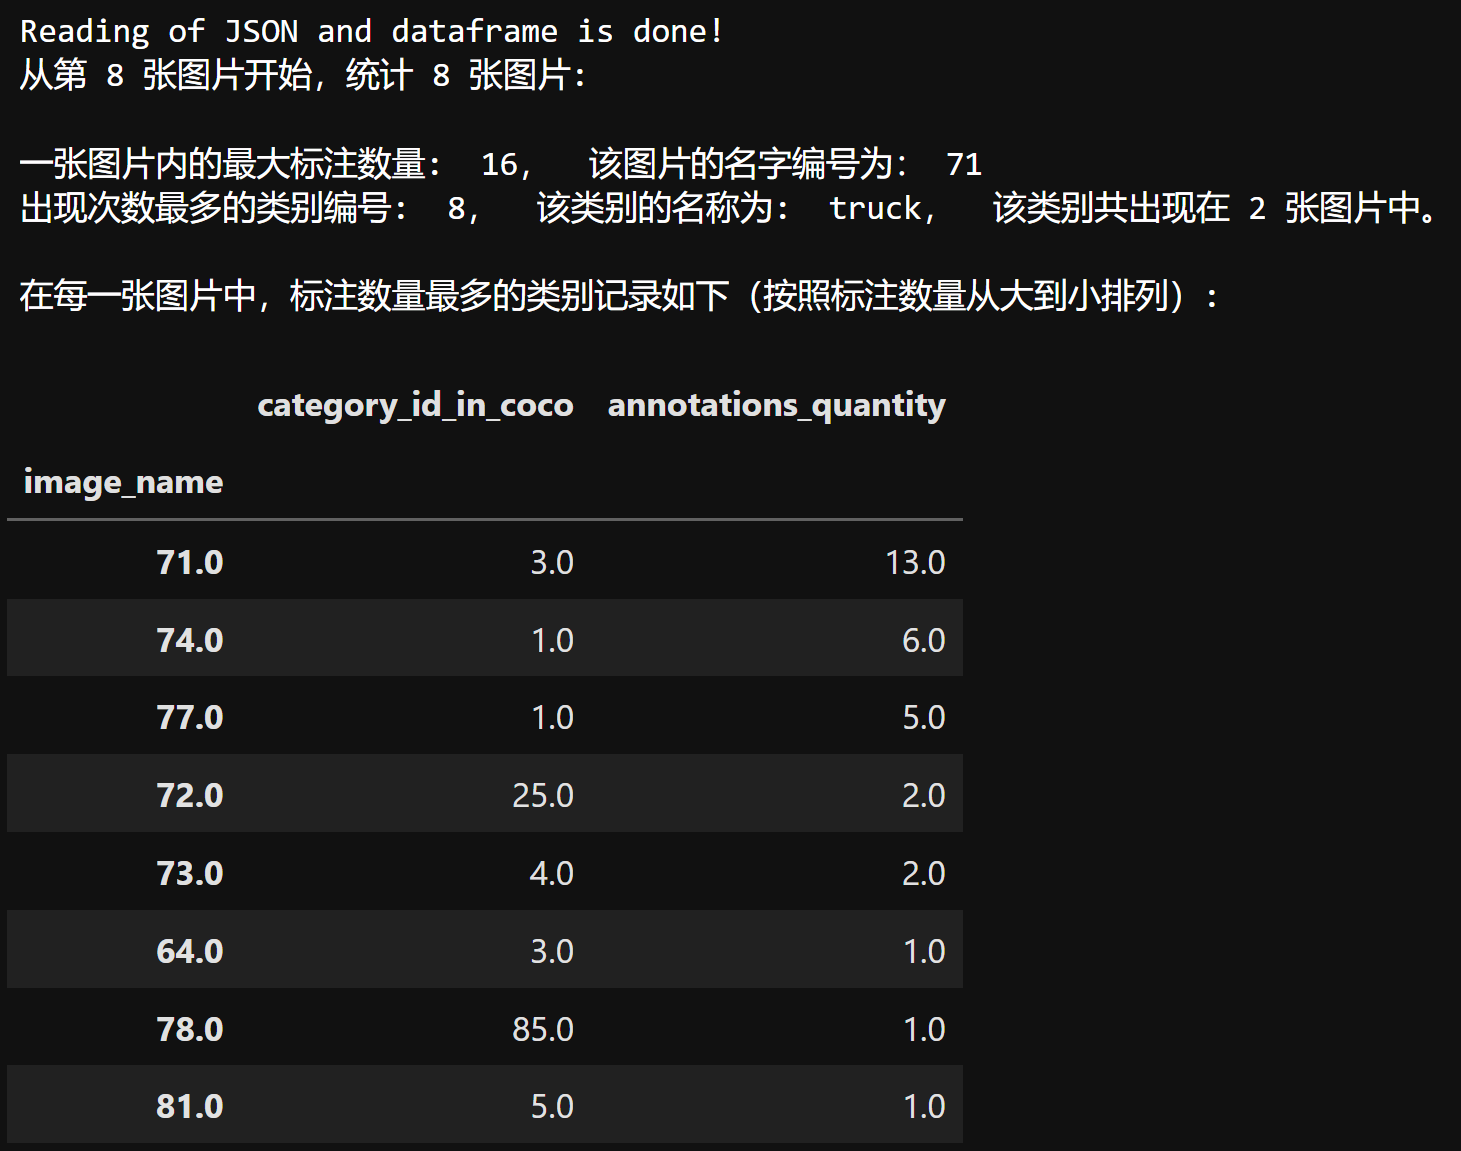